In [1]:
import numpy
from astropy.io.ascii import read as apyread
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Statistics Mini-course Problem Set: solution

The following is a partial solution to the [problem set](http://astro.utoronto.ca/~bovy/statminicourse-2018/assignment1.pdf) for the 2018 Mini-course on ``Statistics and Inference in Astrophysics'' at the University of Toronto.

## Problem 4

*Using the data for Cepheids in the other galaxies we will fit Equation (3). We assume that the parameters of the Leavitt law ($\mathrm{zp}_{W,\mathrm{N4258}}$, $b_W$ , $Z_w$, $V$) are the same for all galaxies (we will again assume intrinsic scatter and assume that it is the same in all galaxies). What are the model parameters? Given what we have done so far, what are good priors for ($\mathrm{zp}_{W,\mathrm{N4258}}$, $b_W$ , $Z_w$, $V$)? Given that we have many parameters, emcee might not work too well, so we will use ``stan`` (e.g., through its Python interface ``PyStan``) to fit and sample this model. Make diagnostic plots of the MCMC chain returned by stan. The main output that we are looking for are the relative distance moduli (μ−μN4258)j. Using the distance modulus of NGC 4258 from point 1) above, compare your distance moduli to those from Table 5 of [Riess et al. (2016)](http://adsabs.harvard.edu/abs/2016ApJ...826...56R)*.

First we read the data, using ``astropy.io.ascii.read``:

In [2]:
data= apyread('./Cepheids data/table4.dat',readme='./Cepheids data/zzz_ReadMe')

This returns a ``Table`` object:

In [26]:
data

<Table length=1486>
Gal    RAdeg    DEdeg      ID      Per     V-I    F160W   sigTot  [O/H] 
        deg      deg                d      mag     mag     mag     [-]  
str5  float64  float64    str8   float64 float64 float64 float64 float64
---- --------- -------- -------- ------- ------- ------- ------- -------
M101 210.87979 54.33376   115287   17.95    0.96   22.47     0.3   9.134
M101 210.89127  54.3562   136682   5.358    1.06   24.41    0.57   9.118
M101 210.89227 54.36125   148312   11.86    1.07   22.94    0.32   9.113
M101 210.89351 54.36826   164932   14.92    1.13   23.03    0.32   9.105
M101 210.87982 54.33565   121146   11.86    0.96   23.14    0.45   9.136
M101 210.89249 54.36142   147959   7.762    1.01   23.79    0.42   9.113
M101 210.87549 54.34114   157556   25.57    1.14   22.75    0.19   9.148
M101 210.88855 54.34493   112715   8.173    0.97    23.8    0.42   9.124
M101 210.88664 54.34654   126118   6.969    0.83   23.84    0.43   9.129
 ...       ...      ...      ...     ...     ...     ...     ...     ...
 M31  11.38113 41.85334 M31_ceph   31.61    1.56   17.45    0.15     8.9
 M31  11.67312 42.14743 M31_ceph   32.01    1.62    17.3    0.15     8.9
 M31  10.96825 41.59107 M31_ceph   32.66    1.63   17.17    0.15     8.9
 M31  11.09981 41.35337 M31_ceph   36.15    1.44   17.17    0.15     8.9
 M31  11.08632 41.33728 M31_ceph   41.22    2.29    17.2    0.15     8.9
 M31  10.92917 41.24755 M31_ceph   43.05    1.78   16.82    0.15     8.9
 M31  11.69675 42.08064 M31_ceph   43.74     1.5   16.97    0.15     8.9
 M31   11.2956  41.6041 M31_ceph   48.45    2.49   17.44    0.15     8.9
 M31  10.91809 41.18565 M31_ceph   56.24    2.07   17.03    0.15     8.9
 M31  11.06418 41.56925 M31_ceph    78.0    1.82   16.05    0.15     8.9

Which galaxies are contained in this data file?

In [27]:
print(set(data['Gal']))

{'N3021', 'N3982', 'N2442', 'M31', 'N1448', 'N3447', 'N4536', 'N4639', 'N5917', 'N1365', 'M101', 'N7250', 'N3972', 'N4258', 'N3370', 'N1309', 'N4038', 'U9391', 'N4424', 'N1015', 'N5584'}


We exclude M31:

In [28]:
data= data[data['Gal'] != 'M31']
print("Data set has {} Cepheids in {} galaxies".format(len(data),len(set(data['Gal']))))

Data set has 1114 Cepheids in 20 galaxies


We add the Wesenheit magnitude (**Note: in the problem set, +0.39 instead of -0.39 was used accidentally; we'll use the correct equation here**):

In [29]:
data['mW']= data['F160W']-0.39*data['V-I']

and make sure the array is sorted by galaxy (which we rely upon below):

In [30]:
data.sort('Gal')

To access the data in ``stan`` below, we stack all of the different galaxies on top of each other, but because the distance modulus is the same for all Cepheids in a given galaxy and this will be a model parameter, we need to keep track of the number of Cepheids in each galaxy and the cumulative number when arranged by galaxy (to easily access the correct distance-modulus parameter in ``stan`` below). We'll also include NGC 4258 itself in the fit (as asked in Bonus Problem 1) and therefore we also need to keep track of where NGC 4258 is in this array, because we have to set its relative distance modulus to NGC 4258 equal to zero!

In [31]:
# Count number of Cepheids in each galaxy
import collections
ceph_count= collections.Counter(data['Gal'])
current_gal= data['Gal'][0]
# Start with 0 to allow cumulative number to start with zero, remove 0 below
ndata_per_galaxy= [0,ceph_count[current_gal]]
n4258_index= 0
foundN4258= False
if not foundN4258 and current_gal != 'N4258': n4258_index+= 1
for gal in data['Gal']:
    if gal == current_gal: pass
    else:
        current_gal= gal
        ndata_per_galaxy.append(ceph_count[current_gal])
        if not foundN4258 and gal != 'N4258':
            n4258_index+= 1
        elif gal == 'N4258':
            foundN4258= True
ndata_per_galaxy= numpy.array(ndata_per_galaxy,dtype='int')
ndata_per_galaxy_cumul= numpy.cumsum(ndata_per_galaxy)
ndata_per_galaxy= ndata_per_galaxy[1:]
ndata_per_galaxy_cumul= ndata_per_galaxy_cumul[:-1]

We write down the ``stan`` model:

In [32]:
import pystan

In [33]:
stan_code = """
data {
    int ngal; # Number of galaxies
    int ndata; # Total number of Cepheids
    int n4258_index; # Index of NGC 4258 in the galaxy array
    int ndata_per_galaxy[ngal]; # Number of Cepheids in galaxy j
    int ndata_per_galaxy_cumul[ngal]; # Cumulative number of Cepheids in galaxy j
    real mWij[ndata]; // Wesenheit magnitude
    real lPij[ndata]; // log_10 Period in days
    real dOHij[ndata]; // Differential log_10 Metallicity
    real sigij[ndata]; // Measurement errors
}
parameters {
    real<lower=-5,upper=10> muRel[ngal-1]; # Distance modulus of galaxy j wrt N4258
    real <lower=25.,upper=28.> zp;
    real <lower=-3.5,upper=-2.5> bW;
    real <lower=-0.5,upper=0.5> Zw;
    real <lower=-10.,upper=10.> lnV;
}
transformed parameters {
    real mu[ndata];
    real sig[ndata];
    real V;
    real this_muRel;
    V= exp(lnV);
    for (i in 1:ngal) {
        if ( i < n4258_index ) {
            this_muRel= muRel[i];
        } else if  ( i > n4258_index ) {
            this_muRel= muRel[i-1];
        } else {
            this_muRel= 0.;
        }
        for (j in 1:ndata_per_galaxy[i]) {
            mu[ndata_per_galaxy_cumul[i]+j] = this_muRel + zp + bW*lPij[ndata_per_galaxy_cumul[i]+j] \
                    + Zw*dOHij[ndata_per_galaxy_cumul[i]+j];
            sig[ndata_per_galaxy_cumul[i]+j] = (sigij[ndata_per_galaxy_cumul[i]+j]^2 + V)^0.5;
        };
    };
}
model {
    mWij ~ normal(mu, sig);
}
"""
stan_model= pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2b1ed5411c73a4bd99ca79a3382de0b7 NOW.


and perform MCMC sampling:

In [34]:
fit= stan_model.sampling(data=dict(ngal=len(set(data['Gal'])),
                                   ndata=len(data),
                                   n4258_index=n4258_index+1,
                                   ndata_per_galaxy=ndata_per_galaxy,
                                   ndata_per_galaxy_cumul=ndata_per_galaxy_cumul,
                                   mWij=data['mW'],
                                   lPij=numpy.log10(data['Per']),
                                   dOHij=data['[O/H]']-8.66,
                                   sigij=data['sigTot']),
                         iter=10000,chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Let's take a look at the chain using ``stan`` tools:

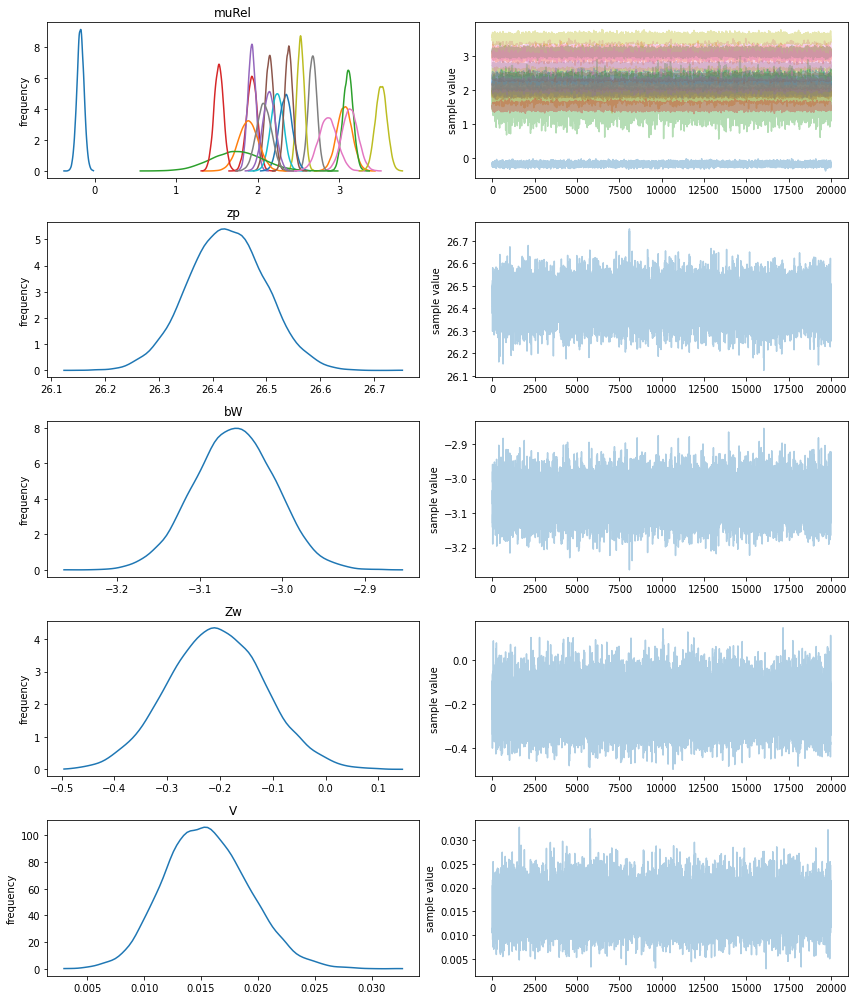

In [35]:
figsize(12,14)
fit.plot(['muRel','zp','bW','Zw','V'])
tight_layout()

and using the ``corner.py`` plotting module for the main Leavitt-law parameter:

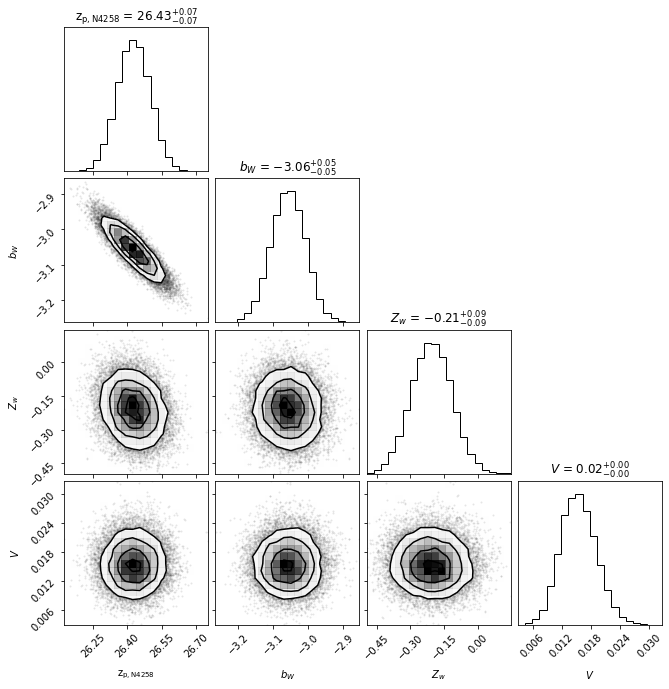

In [36]:
import corner
fig = corner.corner(numpy.array([fit.extract()['zp'],fit.extract()['bW'],
                                 fit.extract()['Zw'],numpy.exp(fit.extract()['lnV'])]).T,
                    labels=["$\mathrm{z}_\mathrm{p,N4258}$",
                            "$b_W$", "$Z_w$", "$V$"],
                    show_titles=True)

We see that all of the parameters of the Leavitt law are much better constrained when they are fit to the data of 20 galaxies simultaneously rather than just to NGC 4258.

The following shows the ``corner`` plot of $z_{\mathrm{p,N4258}}$ and all of the relative distance moduli, which shows that they are all pretty well determined:

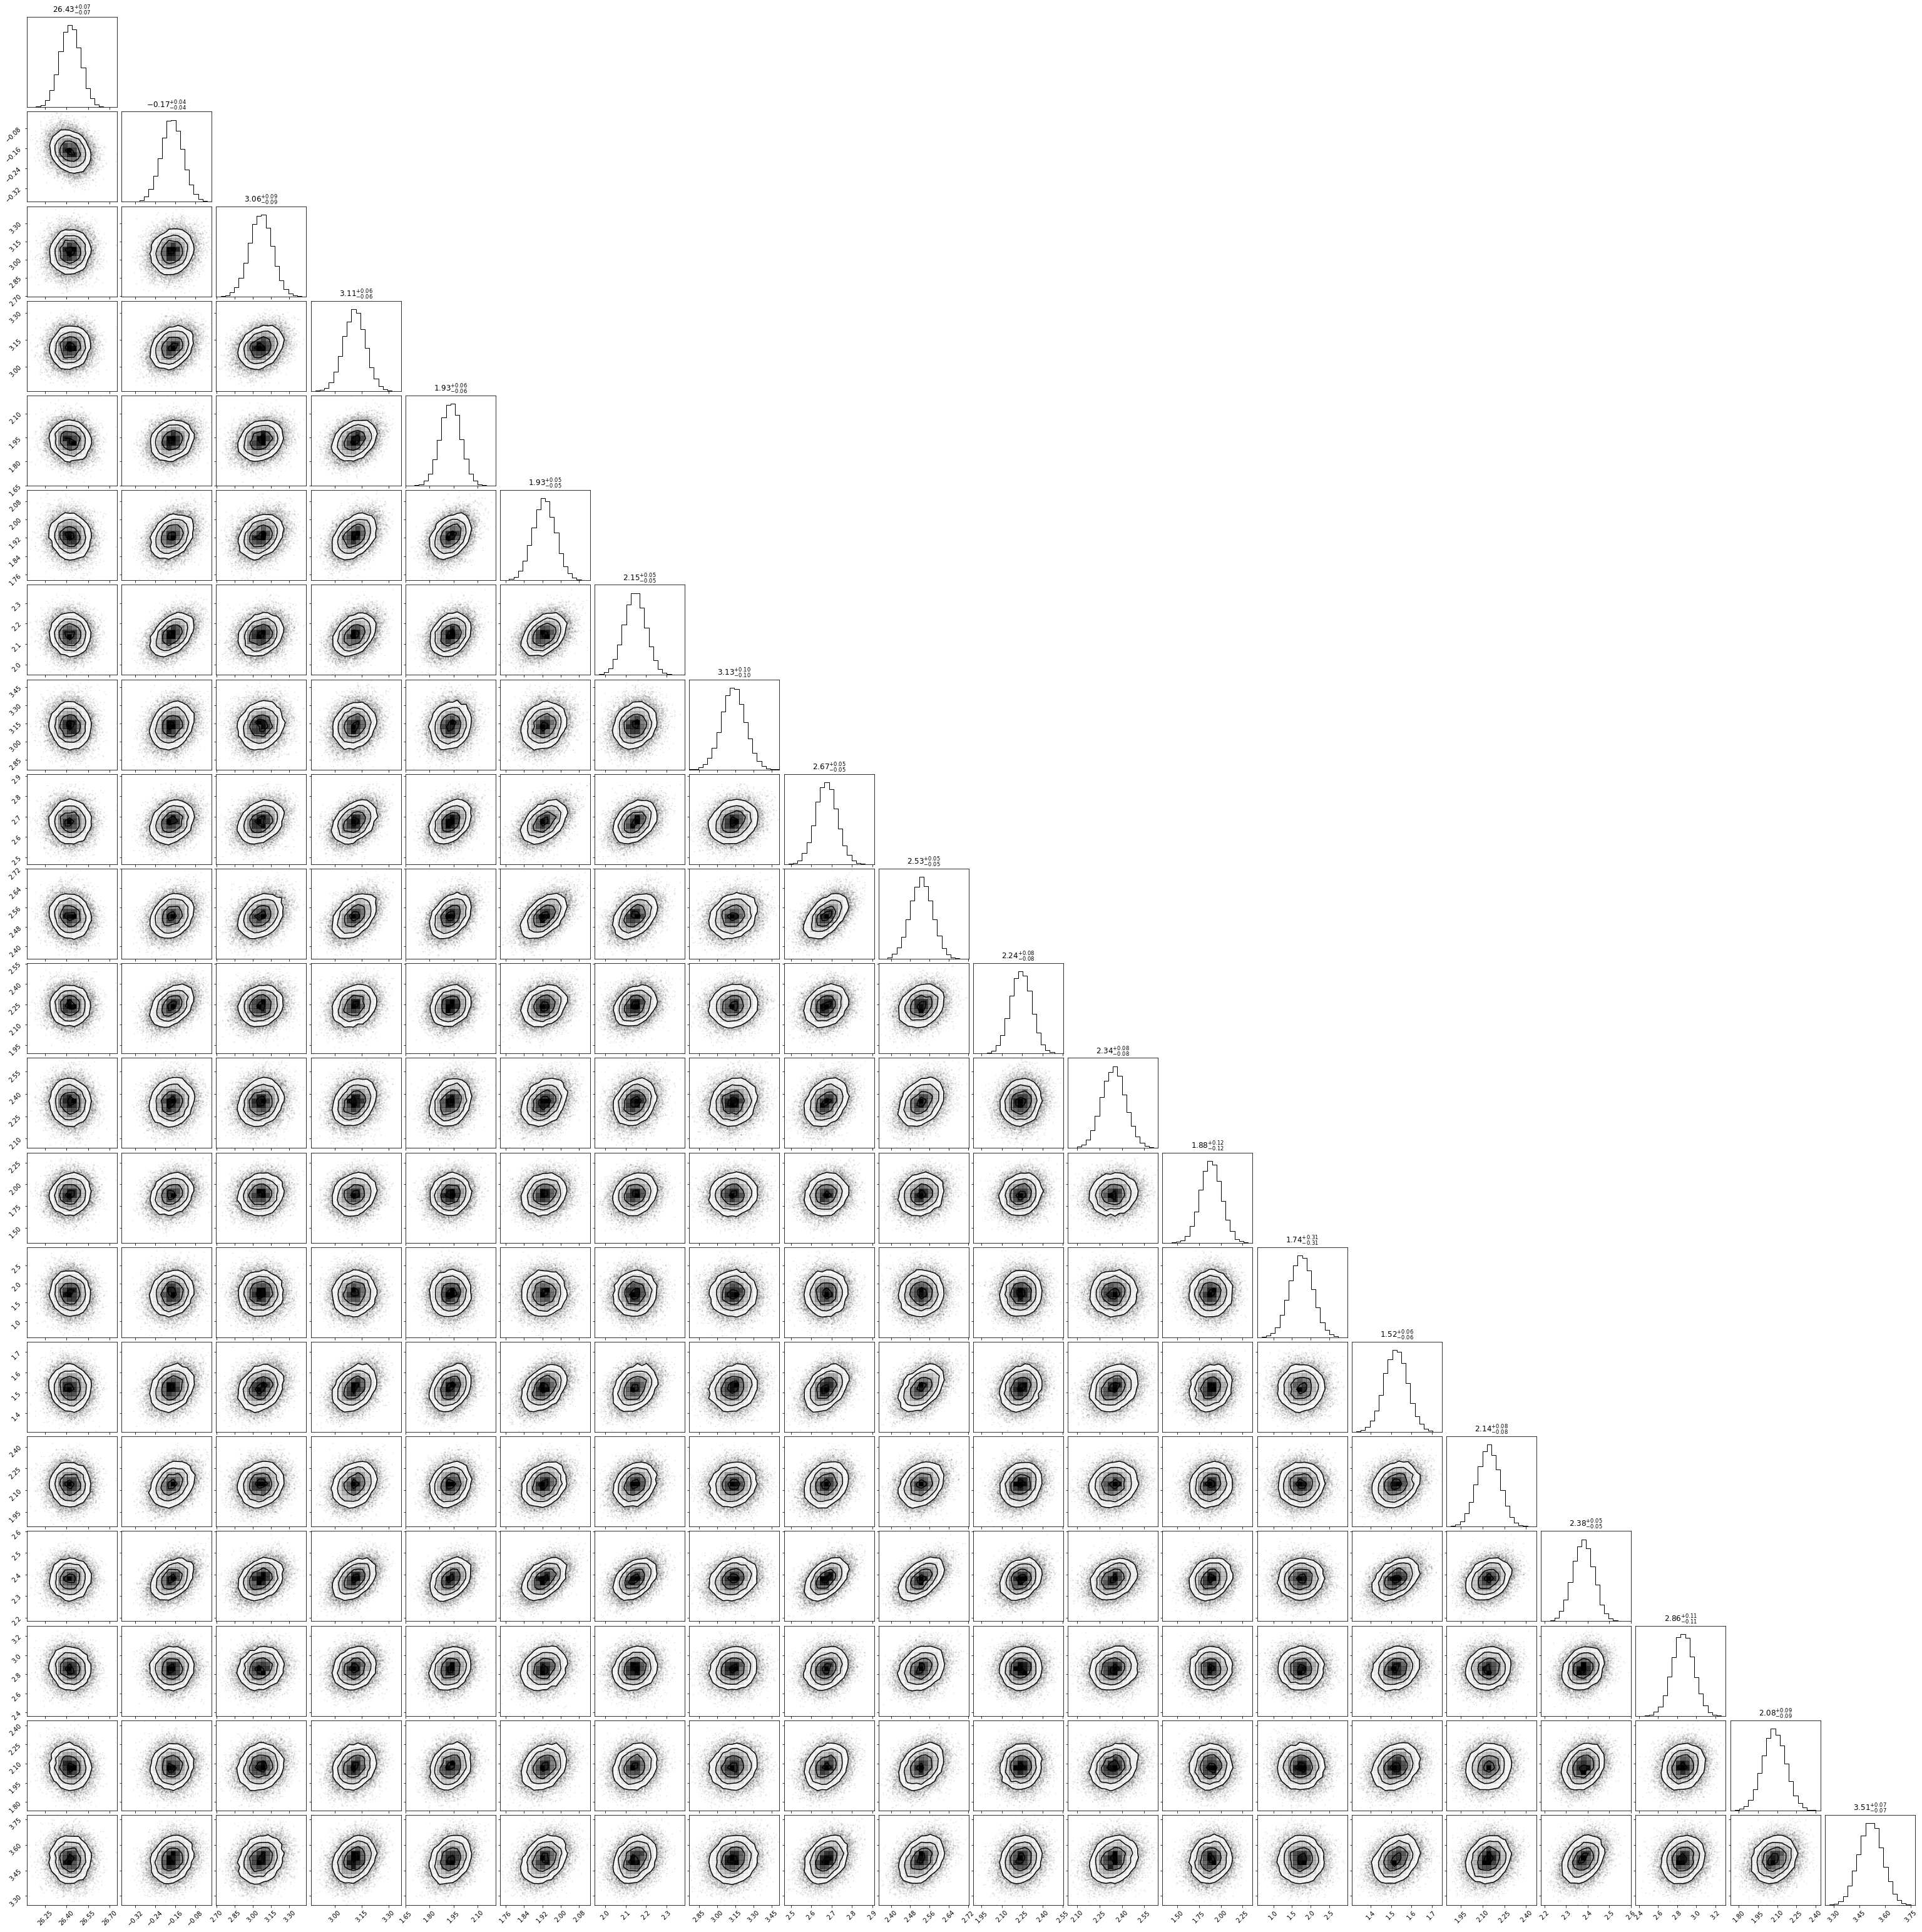

In [37]:
fig = corner.corner(numpy.vstack((fit.extract()['zp'],fit.extract()['muRel'].T)).T,
                    show_titles=True)

Let's compare the relative distance modulus of the galaxies to NGC 4258 to the value found by Riess et al. (2016). First we write down the data from Riess et al.'s Table 5:

In [38]:
# Data for each galaxy: distance modulus, uncertainty
gal_riess= dict(M101=[29.135,0.045],
                N1015=[32.497,0.081],
                N1309=[32.523,0.055],
                N1365=[31.307,0.057],
                N1448=[31.311,0.045],
                N2442=[31.511,0.053],
                N3021=[32.498,0.090],
                N3370=[32.072,0.049],
                N3447=[31.908,0.043],
                N3972=[31.587,0.070],
                N3982=[31.737,0.069],
                N4038=[31.290,0.112],
                N4424=[31.080,0.292],
                N4536=[30.906,0.053],
                N4639=[31.532,0.071],
                N5584=[31.786,0.046],
                N5917=[32.263,0.102],
                N7250=[31.499,0.078],
                U9391=[32.919,0.063])                

and we plot the comparison:

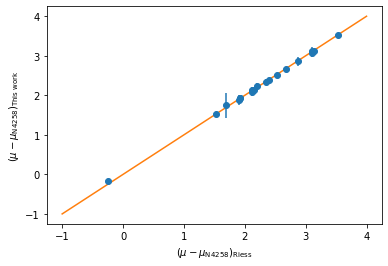

In [39]:
figsize(6,4)
gals= set(data['Gal'])
muRels= fit.extract()['muRel']
errorbar([gal_riess[name][0]-29.387 for name in sorted(gals) if name != 'N4258'],numpy.mean(muRels,axis=0),
          yerr=numpy.std(muRels,axis=0),marker='o',ls='None')
plot([-1,4],[-1,4])
xlabel(r'$(\mu-\mu_{\mathrm{N4258}})_{\mathrm{Riess}}$')
ylabel(r'$(\mu-\mu_{\mathrm{N4258}})_{\mathrm{This\ work}}$');

or more directly:

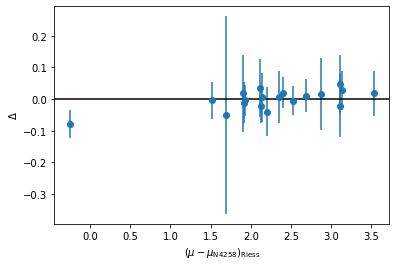

In [40]:
figsize(6,4)
gals= set(data['Gal'])
muRels= fit.extract()['muRel']
errorbar([gal_riess[name][0]-29.387 for name in sorted(gals) if name != 'N4258'],
         [gal_riess[name][0]-29.387 for name in sorted(gals) if name != 'N4258']-numpy.mean(muRels,axis=0),
          yerr=numpy.std(muRels,axis=0),marker='o',ls='None')
axhline(0.,color='k')
xlabel(r'$(\mu-\mu_{\mathrm{N4258}})_{\mathrm{Riess}}$')
ylabel(r'$\Delta$');

The distance moduli that we have measured here agree very well with those from Riess et al. The uncertainties are approximately equal.

## Problem 5

*Combine your measurements of $(\mu − \mu_{\mathrm{N4258}})_j$ from Problem 4 with the data in Table 5 of Riess et al. (2016) to determine the SN Ia magnitude in NGC 4258 $m_{B,\mathrm{N4258}}$ and the Hubble constant $H_0$ using Equations (4) and (5), respectively. Note that the SN Ia magnitudes have uncertainties of their own.*

We start by loading the relevant data from Table 5:

In [41]:
# Data for each galaxy: mB+5aB,uncertainty
snia_riess= dict(M101=[13.310,0.117],
                 N1015=[17.015,0.123],
                 N1309=[16.756,0.116],
                 N1365=[15.482,0.125],
                 N1448=[15.765,0.116],
                 N2442=[15.840,0.142],
                 N3021=[16.527,0.117],
                 N3370=[16.476,0.115],
                 N3447=[16.265,0.124],
                 N3972=[16.048,0.116],
                 N3982=[15.795,0.115],
                 N4038=[15.797,0.114],
                 N4424=[15.110,0.109],
                 N4536=[15.177,0.124],
                 N4639=[15.983,0.115],
                 N5584=[16.265,0.115],
                 N5917=[16.572,0.115],
                 N7250=[15.867,0.115],
                 U9391=[17.034,0.114])

and obtain the measurements of $(m_B+5\,a_B)_i$ for each galaxy as well as $(\mu-\mu_\mathrm{N4258})_i$ (Note that we can do everything in terms of $m_B+5\,a_B$):

In [55]:
mBs = numpy.array([snia_riess[name][0] for name in gals if name != 'N4258'])
mBuncs = numpy.array([snia_riess[name][1] for name in gals if name != 'N4258'])
dms = numpy.mean(muRels,axis=0)
dmuncs = numpy.std(muRels,axis=0)
print(mBs)
print(dms)

[16.527 15.795 15.84  15.765 16.265 15.177 15.983 16.572 15.482 13.31
 15.867 16.048 16.476 16.756 15.797 17.034 15.11  17.015 16.265]
[-0.17286609  3.06387863  3.10823574  1.93100395  1.92742525  2.14579005
  3.13154967  2.67400074  2.52567599  2.23940307  2.34372502  1.88478772
  1.74357132  1.52306717  2.13968605  2.3793097   2.86044622  2.07647136
  3.51428102]


In [58]:
mBs = numpy.array([snia_riess[name][0] for name in sorted(gals) if name != 'N4258'])
mBuncs = numpy.array([snia_riess[name][1] for name in sorted(gals) if name != 'N4258'])
dms = numpy.mean(muRels,axis=0)
dmuncs = numpy.std(muRels,axis=0)


[13.31  17.015 16.756 15.482 15.765 15.84  16.527 16.476 16.265 16.048
 15.795 15.797 15.11  15.177 15.983 16.265 16.572 15.867 17.034]
[-0.17286609  3.06387863  3.10823574  1.93100395  1.92742525  2.14579005
  3.13154967  2.67400074  2.52567599  2.23940307  2.34372502  1.88478772
  1.74357132  1.52306717  2.13968605  2.3793097   2.86044622  2.07647136
  3.51428102]


Each $(m_B+5\,a_B)_i-(\mu-\mu_\mathrm{N4258})_i$ is a noisy estimate of $(m_B+5\,a_B)_{\mathrm{N4258}}$, so we can average them all together using inverse-variance weighting:

In [59]:
mBN4258= numpy.sum((mBs-dms)/(mBuncs**2.+dmuncs**2.))/numpy.sum(1./(mBuncs**2.+dmuncs**2.))
mBN4258unc= numpy.sqrt(1./numpy.sum(1./(mBuncs**2.+dmuncs**2.)))


This then leads to the following Hubble constant (also taking into account the uncertainty on $\mu_{\mathrm{N4258}}$):

In [60]:
H0= 10.**(0.2*(mBN4258-29.387+25.))
H0unc= H0*0.2*numpy.log(10.)*numpy.sqrt(mBN4258unc**2.+0.0568**2.)
print("The Hubble constant is {:.2f} +/- {:.2f} km/s/Mpc"\
          .format(H0,H0unc))

The Hubble constant is 72.84 +/- 2.20 km/s/Mpc


This is a bit bigger than the value that Riess et al. (2016) measure using just NGC 4258 as a distance anchor, likely because we have not attempted to deal with outliers; the uncertainty is very similar.